# Aprendizaje por reforzamiento para el carrito de montaña

Un problema clásico para observar el aprendizaje por reforzamiento en acción, particularmente Aprendizaje Q (*Q-Learning*) es el de mover un automóvil, ubicado entre dos montañas, para subir a la cima de la montaña de la derecha, como se muestra en la imagen abajo.

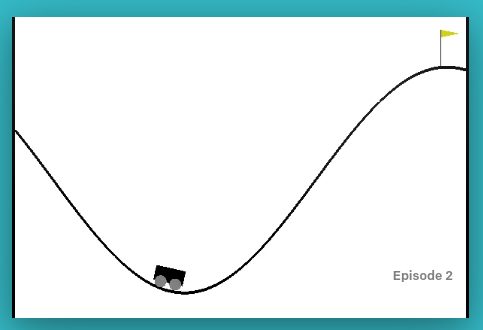

[OpenAI Gym](https://gym.openai.com/) es un conjunto de herramientas que facilitan implementar y probar algoritmos de aprendizaje por computadora, de modo que vamos a utilizarla, así como una biblioteca para hacer cálculo numérico (vectores y matrices) llamada `numpy`, pero que aquí la usaremos con el nombre de `np`.


In [1]:
import gymnasium as gym
import numpy as np

El código que realiza el proceso de aprendizaje se encuentra en la biblioteca `qlearner`, de modo que necesitamos utilizarla también (y la llamaremos `ql`).

In [2]:
import qlearner as ql

## Agente sin inteligencia

Para darnos una idea de como funciona, comenzaremos observando a un *agente* que no tiene mucha idea y elige acciones al azar —el término ‘agente’ se usa mucho en Inteligencia Artificial para hacer referencia a progrmas o sistemas “inteligentes”. Lo llamaremos `test_random` y lo que hace es reiniciar el entorno (el carrito entre las montañas) y realizar acciones al azar hasta que termina el juego.

In [3]:
def test_random(environment):
    # Apenas está comenzando.
    terminated = False
    truncated = False
    # Inicia el entorno y guarda la condición inicial.
    obs = environment.reset()
    
    # Todavía no gana ni perdemos puntos.
    total_reward = 0.0
    
    # Lo que sigue, lo hará hasta que se acabe el juego.
    while not (terminated or truncated):
        # environment.render()
        # Selecciona una acción al azar de entre las posibles.
        action = environment.action_space.sample()
        
        # Ejecuta la acción y recibe información sobre qué dónde está ahora
        # el carrito y qué velocidad tiene, la recompensa/castigo por ejecutar
        # la acción, si ya se acabó el juego e información adicional.
        new_obs, reward, terminated, truncated, info = environment.step(action)
        
        # Actualiza la situación actual.
        obs = new_obs
        
        # Acumula sus puntos
        total_reward += reward
        
    # Cuando termina, informa cuantos puntos logró.
    return total_reward


Vamos a probar este agente solamente tres veces, por cuestiones de memoria en el servidor.

In [4]:
TESTS_NUMBER = 3

def try_random(environment):
    for i in range(TESTS_NUMBER):
        reward = test_random(environment)
        print(f'Rencompensa en prueba {i}: {reward}')


¡Probemos! Comenzamos diciendo qué problema, de todos los que implementados en [OpenAI Gym](https://gym.openai.com/) es el que vamos a utilizar.

In [5]:
environment = gym.make("MountainCar-v0",render_mode='human')

Ahora probamos el agente que toma decisiones al azar. Cuando termine, tardará un poco en presentar la animación de las pruebas, así que ten un poco de paciencia. Una vez que se presente la animación, puedes usar el botón etiquetado como '+' para que el carrito se mueva más rápido.

In [ ]:
try_random(environment)

Cerramos el ambiente que hemos creado

In [7]:
environment.close()

## Agente que aprende

Procedamos ahora a definir la operación de un agente que ha aprendido a resolver el problema. En este caso, la función `test_learner` recibe como argumentos no solamente el ambiente donde va a operar el agente, sino también al agente que aprendió y su estrategia (*policy*).

La estrategia divide el entorno del problema en zonas, de modo que el agente utiliza su observación del entorno para identificar en qué zona se encuentra y luego usa la estrategia para escoger la mejor opción. 

In [8]:
def test_learner(environment, agent, policy):
    terminated = False
    truncated = False
    obs = environment.reset()
    total_reward = 0.0
    while not (terminated or truncated):
        # environment.render()
        # Acción que dictamina la política que hemos entrenado
        action = policy[agent.discretize(obs)] 
        next_obs, reward, terminated, truncated, info = environment.step(action)
        obs = next_obs
        total_reward += reward
    return total_reward


Pero ¿cómo aprende el agente a resolver el problema? Básicamente, intentando miles de veces —incluso para un problema aparentemente sencillo— y usando la ecuación de Q-learning para identificar las mejores acciones en cada situación.

In [9]:
def train_learner(agent, environment):
    best_reward = float('-inf')
    for episode in range(ql.MAX_NUM_EPISODES):
        terminated = False
        truncated = False
        obs = environment.reset()
        total_reward = 0.0
        while not (terminated or truncated):
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = environment.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward
        if total_reward > best_reward:
            randomness = 100*agent.epsilon
            print(f'\nEpisodio: {episode}, recompensa: {total_reward}. Aleatoriedad: {randomness}%')
            best_reward = total_reward
        if (episode % 100) == 0:
            print('.', end = '', flush=True)
 
    ## De la política de entrenamiento que hemos obtenido devolvemos
    # las mejores acciones. Esto es, las que tienen las puntuaciones máximas en cada situación.
    return np.argmax(agent.Q, axis = 2)


Para probar el agente que aprende tenemos que hacerlo aprender primero y luego ponerlo en operación.

In [10]:
def try_learner():
    environment = gym.make("MountainCar-v0",render_mode=None)
    # Creamos un agente capaz de aprender
    agent = ql.QLearner(environment)
    # Lo entrenamos y recuperamos la estrategia (polícy)
    policy = train_learner(agent, environment)
    environment.close()
    environment = gym.make("MountainCar-v0",render_mode='human')
    for i in range(TESTS_NUMBER):
        reward = test_learner(environment, agent, policy)
        print(f'Rencompensa en prueba {i}: {reward}')
    environment.close()

Ahora probamos el agente que aprende. Veremos primero cómo va aprendiendo (obteniendo menos puntos negativos en cada ronda) y luego lo pondremos a trabajar. Como antes, tardará un poco en presentar la animación de las pruebas.

In [ ]:
try_learner()

¡Listo!